In [1]:
import numpy as np
import matplotlib.pyplot as plt

from typing import *

<br>

# Gradient descent
---

<br>

### Basic algorithm

The gradient of a function $f$ always point toward the direction with the steepest ascent. The gradient descent consists in following the reverse of the gradient to follow the steepest descent:

&emsp; $f(x+v) \simeq f(x) + v^T \nabla f(x)$
&emsp; $\implies$
&emsp; descent is steepest when $v$ are $\nabla f(x)$ are in opposite direction

The algorithm therefore proceeds in making a small step in the opposite direction of the gradient:

&emsp; $x_{new} \leftarrow x_{old} - \alpha \nabla f$
&emsp; where
&emsp; $\alpha$ is called the learning rate

This process is stopped when the gradient reaches 0 (critical point). We should not this does ensure we reached a global minimum. It might even in fact not bring us to any local minimum either, as we might stay stuck on a saddle point.

<br>

### Line search

What is the size of the step we should perform? Note that in the previous algorithm, there is one key critical fact: **the larger the gradient, the larger the step**. It might seem counterintuitive, as we might expect that in a region of big variations, we should be more careful about our steps. On the contrary, when variations are small, we might want to do big steps, but that might also make us miss a close critical point.

The thing is that there is not good answer here. One approch is to do a **line search**, that is try different step size:

1. We first double the step size every time until it does not decrease anymore: $\alpha_0, \dots \alpha_n$
2. We then binary search for the best step size in the range $\alpha_{n-1}$ to $\alpha_n$

This requires us to be able to evaluate $f(x - \alpha_i \nabla f)$ at each step. When too costly, this approch is best avoided.

<br>

### Gradient clipping

As mentioned above, the gradient descent algorithm makes big steps when the gradient is big. When the gradient excess a given threshold, these steps might make the algorithm pretty unstable. Because of this, the typical answer is to reduce the learning rate to some low value, so that these big gradient will not lead to too big of a step.

To **avoid having to use a small learning rate** and slow down the all algorithm, another approach is to clip the gradient, forcing it not to go over a given threshold. To make sure the step does not change direction, we scale each dimension the same:

&emsp; $x_{new} \leftarrow x_{old} - \alpha' \nabla f$
&emsp; where
&emsp; $\displaystyle \alpha' = \alpha \frac{\operatorname{max}(\beta, \Vert \nabla f \Vert)}{\Vert \nabla f \Vert}$
&emsp; and
&emsp; $\beta$ is the maximum step size

Gradient clipping might also be used to enforce minimum step size, but is less often used so. We can also in some occasion clip the values by dimension, not keeping the general direction of the descent (**todo: look further**).

<br>

### Momentum

Momentum is another trick that we can use in combination with gradient descent. The goal of momentum is to **avoid getting stuck on saddle points**. Indeed, in many optimization problems such as ANN optimization, getting stuck on a local minima is generally acceptable since the local minimum as in such case statistically not so far away from the global minimum.

Getting stuck on a saddle point is however not acceptable. We avoid this by using a **moving average** for the gradient: the direction $u$ used for descent is a linear combination of the previously used gradient and the gradient computed at the current point.

&emsp; $\displaystyle u_{new} = \beta \, u_{old} + (1 - \beta) \nabla f$
&emsp; and
&emsp; $\displaystyle x_{new} \leftarrow x_{old} - \alpha \, u$

Rewritting the update rule as $\displaystyle u_{new} = u_{old} + (1 - \beta) (\nabla f - u_{old})$, gradient momentum can be seen as a kind of gradient descent of the direction of the descent $u$.

<br>

### Stochastic Gradient Descent (SGD)

If the function to optimize $F$ is a **sum of the a fixed function applied to different inputs** $F = \sum_n f(x_n)$, then the gradient of the function $F$ is the sum of the gradient of the function $f$ applied on these inputs. We can therefore see the gradient of $F$ as an expectation.

&emsp; $\displaystyle F = \sum_n f(x_n)$
&emsp; $\implies$
&emsp; $\displaystyle F = \mathbb{E}_{x \sim X}[f]$
&emsp; and therefore
&emsp; $\displaystyle \nabla F = \mathbb{E}_{x \sim X}[\nabla f]$

The idea of SGD is compute an **estimate of the gradient** $\tilde{\nabla F}$ instead of the gradient to speed up the computations:

&emsp; $x_{new} \leftarrow x_{old} - \alpha \tilde{\nabla f}$
&emsp; where
&emsp; $\displaystyle \tilde{\nabla f} = \frac{1}{K} \sum_k \nabla f(x_k)$
&emsp; on $K$ points randomly picked among the $N$ total points

This works becomes **picking randomly** $K$ points among the $N$ points preserves the fact that the $K$ points will be **drawned from the same distribution** as the $N$ points. This **random sub-selection of the training data** is critical for the estimate to be good.

In practical terms and taking a particular example, SGD might be obtained by picking a mini-batch of 500 inputs among the 60,000 data points in input at each iteration. More sample points means the estimate of the gradient gets better but also more expensive to compute. The random nature of the sub-selection might also help us **avoiding saddle points**: fewer points means more fluctuations and more chances to escape.

<br>

### Example: line search vs fixed learning rate

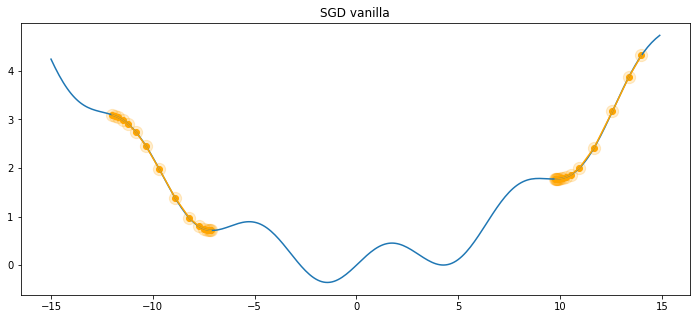

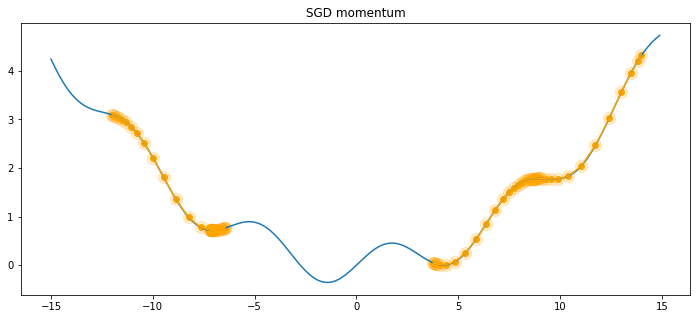

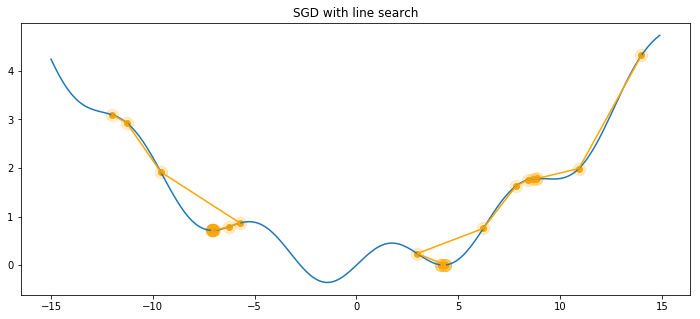

In [10]:
"""
The function to optimize and its derivative
"""

def f_at(xs: np.ndarray):
    return 0.2 * (0.1 * xs ** 2 + 2 * np.sin(xs))

def df_at(xs: np.ndarray):
    return 0.2 * (0.2 * xs + 2 * np.cos(xs))

def df_df_at(xs: np.ndarray):
    return 0.2 * (0.2 - 2 * np.sin(xs))


"""
Gradient descent with fixed rate
"""

def gradient_descent(f, df, x_0: float, lr: float, epoch_nb: int):
    xs = [x_0]
    for _ in range(epoch_nb):
        x = xs[-1]
        xs.append(x - lr * df(x))
    return np.array(xs)


"""
Gradient descent with momentum
"""

def gradient_descent_momentum(f, df, x_0: float, lr: float, momentum: float, epoch_nb: int):
    xs = [x_0]
    descent = 0.
    for _ in range(epoch_nb):
        x = xs[-1]
        descent = momentum * descent + (1 - momentum) * df(x)
        xs.append(x - lr * descent)
    return np.array(xs)


"""
Gradient descent with line search
"""

def line_search(f, x_0, x_1):
    while f(x_1) < f(x_0):
        dx = x_1 - x_0
        x_1 += dx * 4
        x_0 = x_1
    while f(x_1) > f(x_0):
        x_1 = x_0 + (x_1 - x_0) / 2
    return x_1

def gradient_descent_ls(f, df, x_0: float, lr: float, epoch_nb: int):
    xs = [x_0]
    for _ in range(epoch_nb):
        x = xs[-1]
        xs.append(line_search(f, x, x - lr * df(x)))
    return np.array(xs)


"""
Plotting the result
"""

def plot_gd(xs, color):
    plt.plot(xs, f_at(xs), color=color)
    plt.scatter(xs, f_at(xs), color=color)
    plt.scatter(xs, f_at(xs), s=150, color=color, alpha=0.2)


xs = np.arange(-15., 15., 0.1)
                  
plt.figure(figsize=(12, 5))
plt.plot(xs, f_at(xs))
plot_gd(gradient_descent(f_at, df_at, -12, 1.0, 15), color='orange')
plot_gd(gradient_descent(f_at, df_at, +14, 1.0, 15), color='orange')
plt.title("SGD vanilla")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(xs, f_at(xs))
plot_gd(gradient_descent_momentum(f_at, df_at, -12, 1.0, 0.7, 45), color='orange')
plot_gd(gradient_descent_momentum(f_at, df_at, +14, 1.0, 0.7, 45), color='orange')
plt.title("SGD momentum")
plt.show()
    
plt.figure(figsize=(12, 5))
plt.plot(xs, f_at(xs))
plot_gd(gradient_descent_ls(f_at, df_at, -12, 1.0, 15), color='orange')
plot_gd(gradient_descent_ls(f_at, df_at, +14, 1.0, 15), color='orange')
plt.title("SGD with line search")
plt.show()

<br>

# Newton method
---

<br>

### Basic algorithm

The Newton's algorithm is built to found the zeros of a function. It consists in constructing the tangent of the function at the point $x_i$ and compute the position at which the tangent crosses $y=0$, and take that next point as $x_{i+1}$. It flows from the **order 1 Taylor expansion**:

&emsp; $f(x_{new}) \simeq f(x_{old}) + (x_{new}-x_{old}) f'(x_{old}) = 0$
&emsp; $\implies$
&emsp; $\displaystyle x_{new} = x_{old} - \frac{f(x_{old})}{f'(x_{old})}$

**When applied to an optimization problem**, it is used to find the critical points of a function $f$, that is the point such as $\nabla f = 0$:

&emsp; $\displaystyle x_{new} = x_{old} - \frac{f'(x_{old})}{f''(x_{old})}$

We compare below the trajectory with the gradient descent approaches.

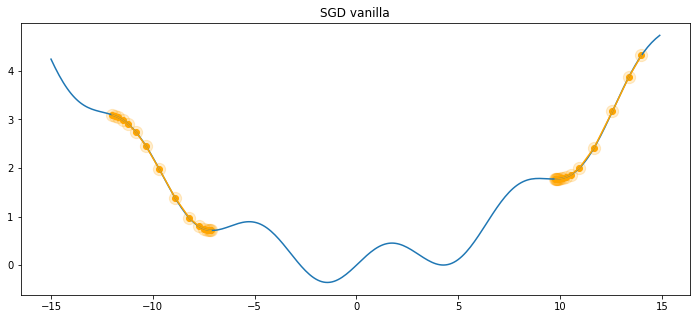

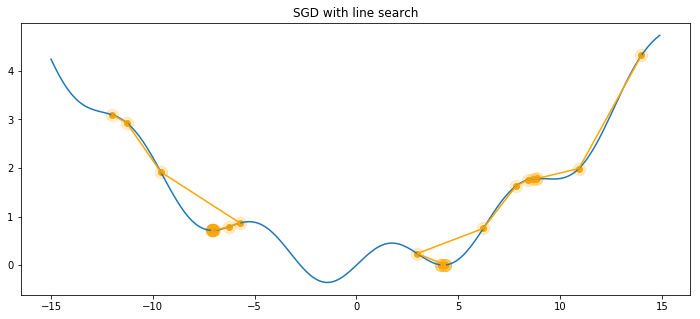

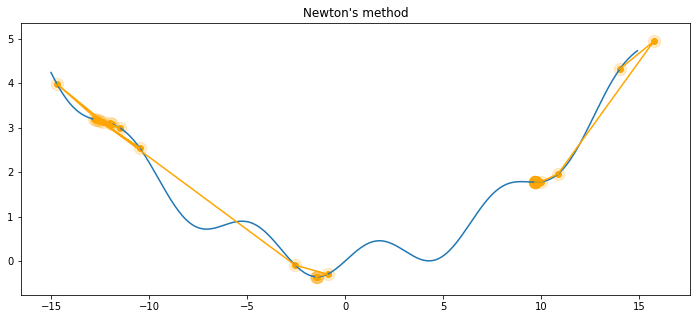

In [3]:
"""
Newton's method
"""

def newton_method(f, df, ddf, x_0: float, lr: float, epoch_nb: int) -> float:
    xs = [x_0]
    for _ in range(epoch_nb):
        x = xs[-1]
        if ddf(x) == 0:
            break
        xs.append(x - lr * df(x) / ddf(x))
    return np.array(xs)


"""
Plotting the result
"""

def plot_gd(xs, color):
    plt.plot(xs, f_at(xs), color=color)
    plt.scatter(xs, f_at(xs), color=color)
    plt.scatter(xs, f_at(xs), s=150, color=color, alpha=0.2)


xs = np.arange(-15., 15., 0.1)
          
plt.figure(figsize=(12, 5))
plt.plot(xs, f_at(xs))
plot_gd(gradient_descent(f_at, df_at, -12, 1.0, 15), color='orange')
plot_gd(gradient_descent(f_at, df_at, +14, 1.0, 15), color='orange')
plt.title("SGD vanilla")
plt.show()
    
plt.figure(figsize=(12, 5))
plt.plot(xs, f_at(xs))
plot_gd(gradient_descent_ls(f_at, df_at, -12, 1.0, 15), color='orange')
plot_gd(gradient_descent_ls(f_at, df_at, +14, 1.0, 15), color='orange')
plt.title("SGD with line search")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(xs, f_at(xs))
plot_gd(newton_method(f_at, df_at, df_df_at, -12, 1.0, 15), color='orange')
plot_gd(newton_method(f_at, df_at, df_df_at, +14, 1.0, 15), color='orange')
plt.title("Newton's method")
plt.show()

These graph illustrates that the Newton's method leads to some **non-intuitive behavior**, because it tries to **converge to critical points**, which can be local minimum, local maximum, or just a saddle points.

<br>

### Multivariate version (searching zeros)

The multivariate version of the Newton's method is also based on the **order 1 Taylor expansion**:

&emsp; $f(x) \simeq f(a) + (x - a)^T \nabla f (a) = 0$
&emsp; $\implies$
&emsp; $x^T \nabla f(a) = a^T \nabla f(a) - f(a)$

We would like to divide by the gradient, but this is not a valid operation. In fact, **this problem is under-constrained** (1 equation for $N$ unknowns) and so there are many possible solutions. For instance, we could decide to fix all components of $x$ to be equal to $a$ except for one, and solve for this component, leading to the same approach as the univariate approach. This is illustrated below for two components:

&emsp; $\displaystyle df = \frac{\partial f}{\partial x} dx + \frac{\partial f}{\partial y} dy = -f(a)$
&emsp; $\implies$
&emsp; $\displaystyle dx = - \frac{f(a)}{f_x}$
&emsp; or
&emsp; $\displaystyle dy = - \frac{f(a)}{f_y}$

We can also choose these two variables such that they are proportional to a constant $\alpha$ and proportional to their respective partial derivative: $dx = \alpha f_x$, $dy = \alpha f_y$ and $(x-a) = \alpha \nabla f$. This reduces the problem to a single variable and single equation, which we can solve:

&emsp; $df = \alpha f_x^2 + \alpha f_y^2 = -f(a)$
&emsp; $\implies$
&emsp; $\displaystyle \alpha = - \frac{f(a)}{\Vert \nabla f \Vert^2}$
&emsp; $\implies$
&emsp; $\boxed{x_{new} = x_{old} - \frac{f(x_{old})}{\Vert \nabla f(x_{old}) \Vert^2} \nabla f(x_{old})}$

We can check that this formulation is equal to our usual formula when $x$ is a single variable. We can also view this formula as simply **following the steepest line toward the zero value**.

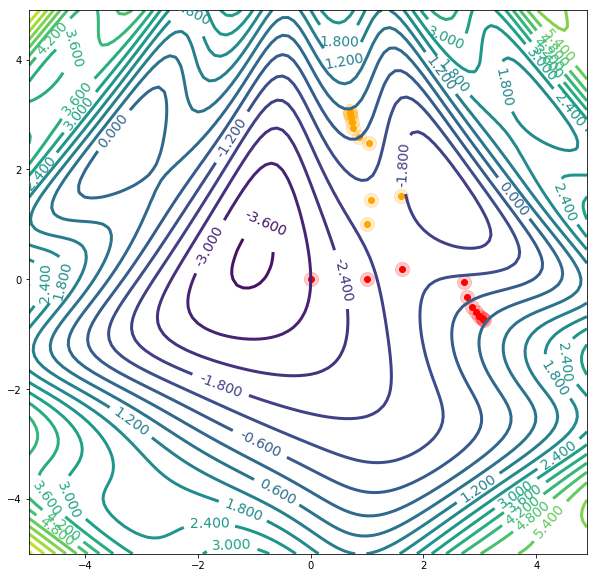

In [28]:
"""
A function and its derivative
"""

def z_at(xs, ys):
    return 0.2 * (xs**2 + ys**2) + np.sin(0.5 * xs * ys + xs) - 3.

def grad_z_at(x, y):
    f_x = 0.4 * x + (0.5 * y + 1) * np.cos(0.5 * x * y + x)
    f_y = 0.4 * y + (0.5 * x) * np.cos(0.5 * x * y + x)
    return np.array([f_x, f_y])

def hessian_at(x, y):
    f_x_x = 0.4 - (0.5 * y + 1)**2 * np.sin(0.5 * x * y + x)
    f_y_y = 0.4 - (0.5 * x)**2 * np.sin(0.5 * x * y + x)
    f_x_y = 0.5 * np.cos(0.5 * x * y + x) - (0.5 * y + 1) * (0.5 * x) * np.sin(0.5 * x * y + x)
    return np.array([[f_x_x, f_x_y], [f_x_y, f_y_y]])
    

"""
Newton's method to find the zeros
"""


def find_zeros_newton(x: float, y: float, epoch_nb: int, lr: float) -> np.ndarray:
    points = []
    pos = np.array([x, y])
    points.append(pos)
    for _ in range(epoch_nb):
        x, y = pos
        grad = grad_z_at(x, y)
        pos = pos - lr * z_at(x, y) / np.dot(grad, grad) * grad
        points.append(pos)
    return np.stack(points)


"""
Display the results
"""

def display_points(points_newton, color):
    ax.scatter(points_newton[:,0], points_newton[:,1], color=color)
    ax.scatter(points_newton[:,0], points_newton[:,1], s=200, color=color, alpha=0.2)

xs = np.arange(-5., 5., 0.1)
ys = np.arange(-5., 5., 0.1)
X, Y = np.meshgrid(xs, ys)
Z = z_at(X, Y)

fig, ax = plt.subplots(figsize=(10, 10))
CS = ax.contour(X, Y, Z, levels=20, linewidths=3, antialiased=True)
display_points(find_zeros_newton(0, 0, epoch_nb=10, lr=0.33), color='red')
display_points(find_zeros_newton(1, 1, epoch_nb=10, lr=0.33), color='orange')
ax.clabel(CS, inline=1, fontsize=14)
plt.show()

<br>

### Multivariate version (optimization)

The optimization version of the Newton's method is pretty **computer intensive** due to need to compute the Jacobian of the gradient $J_{\nabla f}$, also known as the Hessian matrix $H$, and sometimes written $\nabla \nabla f$:

&emsp; $\nabla f (x) \simeq  \nabla f(a) + H(a) (x-a) = 0$
&emsp; $\implies$
&emsp; $x = a - H(a)^{-1} \nabla f(a)$

Note that **the inverse of the Hessian might not exist**. It usually works here because the Hessian matrix is symmetric, and so its eigenvalues are real, and in the general case, these eigenvalues will not be equal to zero (allowing the inverse to be computed).

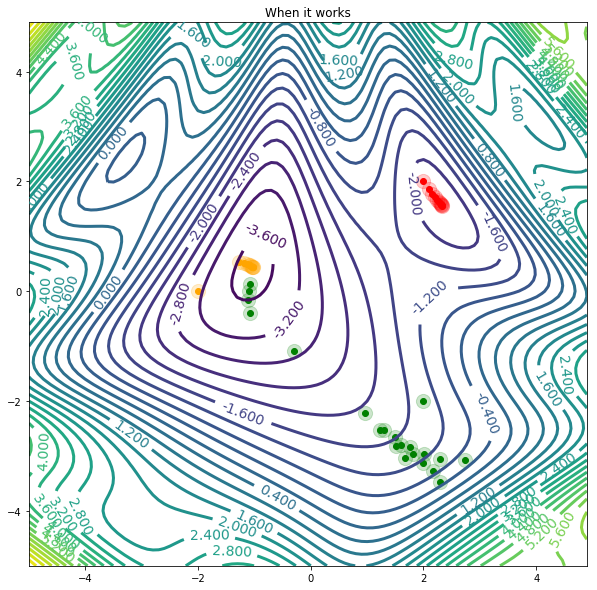

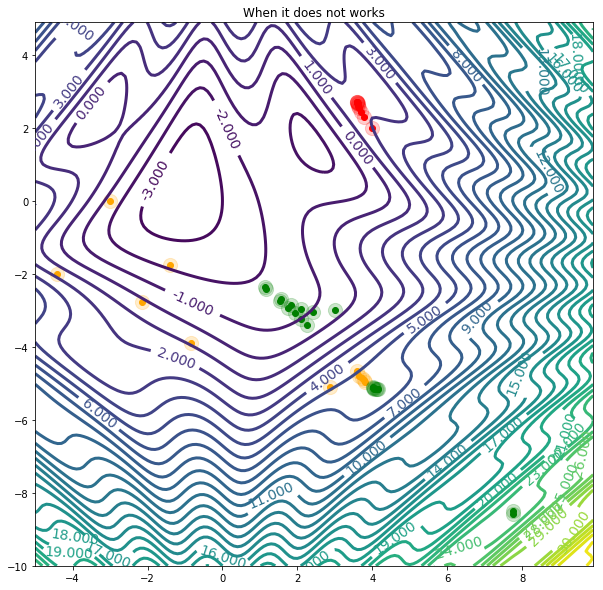

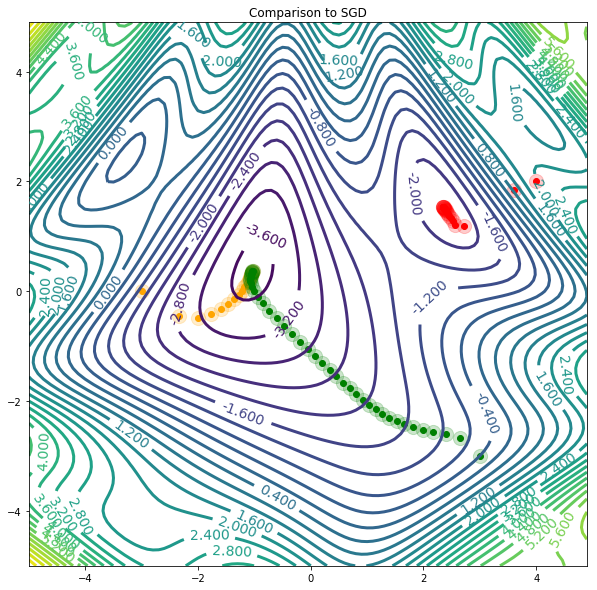

In [71]:
"""
Newton's method to find the minimum
"""

def optimize_with_newton(x: float, y: float, epoch_nb: int, lr: float) -> np.ndarray:
    points = []
    pos = np.array([x, y])
    points.append(pos)
    for _ in range(epoch_nb):
        x, y = pos
        grad = grad_z_at(x, y)
        hess = hessian_at(x, y)
        pos = pos - lr * np.linalg.inv(hess) @ grad
        points.append(pos)
    return np.stack(points)


"""
Gradient descent
"""

def gradient_descent(x: float, y: float, epoch_nb: int, lr: float) -> np.ndarray:
    points = []
    pos = np.array([x, y])
    points.append(pos)
    for _ in range(epoch_nb):
        x, y = pos
        pos = pos - lr * grad_z_at(x, y)
        points.append(pos)
    return np.stack(points)


"""
Display the results
"""

xs = np.arange(-5., 5., 0.1)
ys = np.arange(-5., 5., 0.1)
X, Y = np.meshgrid(xs, ys)
Z = z_at(X, Y)

fig, ax = plt.subplots(figsize=(10, 10))
CS = ax.contour(X, Y, Z, levels=30, linewidths=3, antialiased=True)
display_points(optimize_with_newton(2, 2, epoch_nb=10, lr=0.3), color='red')
display_points(optimize_with_newton(-2, 0, epoch_nb=10, lr=0.3), color='orange')
display_points(optimize_with_newton(2, -2, epoch_nb=20, lr=0.3), color='green')
ax.clabel(CS, inline=1, fontsize=14)
plt.title('When it works')
plt.show()

xs = np.arange(-5., 10., 0.1)
ys = np.arange(-10., 5., 0.1)
X, Y = np.meshgrid(xs, ys)
Z = z_at(X, Y)

fig, ax = plt.subplots(figsize=(10, 10))
CS = ax.contour(X, Y, Z, levels=40, linewidths=3, antialiased=True)
display_points(optimize_with_newton(4, 2, epoch_nb=10, lr=0.3), color='red')
display_points(optimize_with_newton(-3, 0, epoch_nb=10, lr=0.3), color='orange')
display_points(optimize_with_newton(3, -3, epoch_nb=20, lr=0.3), color='green')
ax.clabel(CS, inline=1, fontsize=14)
plt.title('When it does not works')
plt.show()

xs = np.arange(-5., 5., 0.1)
ys = np.arange(-5., 5., 0.1)
X, Y = np.meshgrid(xs, ys)
Z = z_at(X, Y)

fig, ax = plt.subplots(figsize=(10, 10))
CS = ax.contour(X, Y, Z, levels=30, linewidths=3, antialiased=True)
display_points(gradient_descent(4, 2, epoch_nb=20, lr=0.3), color='red')
display_points(gradient_descent(-3, 0, epoch_nb=20, lr=0.3), color='orange')
display_points(gradient_descent(3, -3, epoch_nb=40, lr=0.3), color='green')
ax.clabel(CS, inline=1, fontsize=14)
plt.title('Comparison to SGD')
plt.show()

<br>

# Simulated Annealing / Beam Search / Genetic Algorithms
---

There are case, such as discrete variables, or non derivable function, in which we do not have the luxuary of having a direction toward which a value decreases.

<br>

### Local search

* Start with an initial solution
* Perform some changes on the solution
* Pick the new solution if better or else drop it
* Stop when there are no more improvement

Akin to steepest descent (not quite, we just go for a descent, not necessarily the steepest). Gets stuck on local minimum.

<br>

### Beam search

Same as local search, but instead of always following one best solution, keep track of several good solutions at the same time. We keep several changes on the solution and expand them, keeping always the $K$ best solutions.

Equivalent to running several local search except that we allow some crossing between the independent searches. The big disadvantage is that if the solutions are too similar, the space searched is too narrow and does not allow to escape local minimum.

**Randomized beam search** helps in that regard by making sure we do not always select the best solution. Instead, we have a higher chance of selecting worse solution, so that the scope of search of the *beam* is enlarged.

<br>

### Genetic Algorithms

* mutation is like gradient descent
* crossing is like escape from local minimum
* crossing encourages solution in which co-dependencies are not too great (optimizing for coopération)

GA is exactly Randomized Beam search when crossing are not considered: a lot of GA is actually randomized beam search.

<br>

### Simulated Annealing

As randomized beam search, the idea is not to always keep the best solution but too allow worse solutions to be selected, but this probability changes with time, based on *temperature*. The all technique consits in decreasing the temperature over time, increasing it again, then decreasing it again, etc.

The goal is that low temperature encourage following the steepest descent (and find local minimum) while the high temperature phases allow to escape these local minimum.

We can of course combine this with randomized beam search (and have several solutions tracked at the same time).